# Colab part

## Download the data

In [1]:
import gdown

In [2]:
sharing_link_train = "https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing"
gdown.download(url=sharing_link_train, output="./data_train.zip", quiet=False, fuzzy=True)

sharing_link_test = "https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing"
gdown.download(url=sharing_link_test, output="./data_test.zip", quiet=False, fuzzy=True)

!unzip -o -qq data_train.zip -d train_data
!unzip -o -qq data_test.zip -d test_data

Downloading...
From (original): https://drive.google.com/uc?id=1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16
From (redirected): https://drive.google.com/uc?id=1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16&confirm=t&uuid=3593c528-ebe6-4b36-9bec-f6e19e8ab308
To: /content/data_train.zip
100%|██████████| 2.28G/2.28G [00:34<00:00, 66.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K
From (redirected): https://drive.google.com/uc?id=12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K&confirm=t&uuid=11ffef46-9e8b-4c9e-ae41-3a4c9de859b7
To: /content/data_test.zip
100%|██████████| 222M/222M [00:06<00:00, 33.5MB/s]


## Data preprocessing

In [3]:
import os

import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [5]:
emotions = os.listdir('./train_data/train/')

# для перевода эмоций в индексы и наоборот
idx2emotions = {i:v for i, v in enumerate(emotions)}
emotions2idx = {v:i for i, v in enumerate(emotions)}

all_train_images = []
all_train_labels = []
for emotion in emotions:
    for filename in os.listdir('./train_data/train/'+emotion):
        all_train_images.append('./train_data/train/'+emotion+'/'+filename)
        all_train_labels.append(emotions2idx[emotion])

train_images, test_images, train_labels, test_labels = train_test_split(
    all_train_images,
    all_train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## Dalaset and dataloader

In [6]:
class MyTrainDataset(Dataset):

    def __init__(self, images, labels, img_size=48, to_float=True):
        self.images = images
        self.labels = labels
        self.to_float = to_float
        self.transform = T.Compose([T.ToTensor(), T.Resize((img_size,img_size))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = self.transform(Image.open(img_name))
        if self.to_float:
            image = image / 255.
        return image, label

In [7]:
batch_size = 32

train_dataset = MyTrainDataset(images=train_images, labels=train_labels)
test_dataset = MyTrainDataset(images=test_images, labels=test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Model

In [8]:
from torch import nn

from torchvision import models

In [32]:
class Net(nn.Module):
    def __init__(self, num_classes=9, embedding_len=256):
        super(Net, self).__init__()
        self.pretrained = models.resnet34(weights='IMAGENET1K_V1') # основная сеть
        self.embedding = nn.Linear(1000, embedding_len) # а это надстройка для моей классификации
        self.bn = nn.BatchNorm1d(embedding_len) # это тоже
        self.output = nn.Linear(embedding_len, num_classes) # и это

    def forward(self, x):
        x = self.pretrained(x)
        x = self.embedding(x)
        x = self.bn(x)
        x = self.output(x)
        return x

## Train and test functions

In [10]:
import torch

from tqdm import tqdm

In [11]:
def train(model, criterion, batch_size, device, train_loader, optimizer, epoch):

    model.train()
    running_loss = 0.0
    running_corrects = 0.0

    print(f"---------- Epoch {epoch} ----------")

    for _, (inputs, labels) in enumerate(tqdm(train_loader)):

        # перемещаем все на ГПУ
        inputs, labels = inputs.to(device), labels.to(device)

        # инферим модель
        outputs = model(inputs)

        # обнуляем градиенты, считаем лосс и пробрасываем его назад, делаем шаг оптимизации
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вычисляем предсказанные классы
        _, preds = torch.max(outputs, 1)

        # добавляем лосс и точность на батче в общий список
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # считаем лосс и точность на эпохе
    epoch_loss = running_loss / (len(train_loader)*batch_size)
    epoch_acc = running_corrects / (len(train_loader)*batch_size)

    print('TRAIN: epoch {} loss: {:.4f}, acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))


def test(model, criterion, batch_size, device, test_loader):

    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    print(f"---------- Testing ----------")

    for _, (inputs, labels) in enumerate(tqdm(test_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / (len(test_loader)*batch_size)
    epoch_acc = running_corrects / (len(test_loader)*batch_size)

    print('TEST: loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))

## Training

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 7

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.4MB/s]


In [13]:
for i in range(num_epochs):
    train(model, criterion, batch_size, device, train_loader, optimizer, i)
    test(model, criterion, batch_size, device, test_loader)

---------- Epoch 0 ----------


100%|██████████| 1252/1252 [06:36<00:00,  3.16it/s]


TRAIN: epoch 0 loss: 1.8589, acc: 0.3245
---------- Testing ----------


100%|██████████| 313/313 [01:38<00:00,  3.18it/s]


TEST: loss: 1.7260, acc: 0.3763
---------- Epoch 1 ----------


100%|██████████| 1252/1252 [06:31<00:00,  3.20it/s]


TRAIN: epoch 1 loss: 1.6433, acc: 0.4060
---------- Testing ----------


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


TEST: loss: 1.6415, acc: 0.4040
---------- Epoch 2 ----------


100%|██████████| 1252/1252 [06:39<00:00,  3.14it/s]


TRAIN: epoch 2 loss: 1.5326, acc: 0.4483
---------- Testing ----------


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


TEST: loss: 1.6230, acc: 0.4062
---------- Epoch 3 ----------


100%|██████████| 1252/1252 [06:41<00:00,  3.12it/s]


TRAIN: epoch 3 loss: 1.4230, acc: 0.4899
---------- Testing ----------


100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


TEST: loss: 1.7058, acc: 0.3943
---------- Epoch 4 ----------


100%|██████████| 1252/1252 [06:36<00:00,  3.16it/s]


TRAIN: epoch 4 loss: 1.3026, acc: 0.5341
---------- Testing ----------


100%|██████████| 313/313 [01:39<00:00,  3.15it/s]


TEST: loss: 1.6615, acc: 0.4198
---------- Epoch 5 ----------


100%|██████████| 1252/1252 [06:20<00:00,  3.29it/s]


TRAIN: epoch 5 loss: 1.1537, acc: 0.5874
---------- Testing ----------


100%|██████████| 313/313 [01:34<00:00,  3.30it/s]


TEST: loss: 1.7731, acc: 0.4270
---------- Epoch 6 ----------


100%|██████████| 1252/1252 [06:29<00:00,  3.21it/s]


TRAIN: epoch 6 loss: 0.9684, acc: 0.6574
---------- Testing ----------


100%|██████████| 313/313 [01:37<00:00,  3.21it/s]

TEST: loss: 1.9437, acc: 0.4121


In [14]:
# сохраняем веса
torch.save(model, 'resnet_34_7e.pth')

## Completing submission

In [15]:
import numpy as np
import pandas as pd

In [16]:
class MyPredictDataset(Dataset):

    def __init__(self, images, img_size=48, to_float=True):
        self.images = images
        self.to_float = to_float
        self.transform = T.Compose([T.ToTensor(), T.Resize((img_size,img_size))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = self.transform(Image.open(img_name))
        if self.to_float:
            image = image / 255.
        return image

In [17]:
submit_images = ['./test_data/test_kaggle/'+str(i)+'.jpg' for i in range(len(os.listdir('./test_data/test_kaggle')))]

batch_size = 32

submit_dataset = MyPredictDataset(images=submit_images)
submit_loader = DataLoader(submit_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [18]:
def predict(model, device, submit_loader):

    model.eval()
    predictions = np.array([])

    print(f"---------- Predicting ----------")

    for _, (inputs) in enumerate(tqdm(submit_loader)):

        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions = np.concatenate([predictions, preds.cpu()])

    return predictions

In [20]:
predictions = predict(model, device, submit_loader)

---------- Predicting ----------


100%|██████████| 157/157 [00:48<00:00,  3.25it/s]


In [ ]:
# собираем датафрейм
predicted_emotions = [idx2emotions[p] for p in predictions]
submission = pd.DataFrame(data=np.array([[str(i)+'.jpg' for i in range(len(submit_images))], predicted_emotions]).T,
                          columns=['image_path', 'emotion'])
submission.set_index('image_path', inplace=True)

In [ ]:
submission.to_csv('submission_1.csv')

# Local part

## Camera setup

In [1]:
import cv2
import torch

from torch import nn

import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
# запускаем камеру
cam = cv2.VideoCapture(0)

if not cam.isOpened():
    print("Не удалось открыть камеру")
else:
    print("Камера запущена")

cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640) # ширина кадра -- 640 пикселей
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # высота кадра -- 480 пикселей

Камера запущена


True

## Stuff for emotion recognition

In [3]:
# отдельно, так как эта часть не знает про train папки. Однако порядок эмоций сохранен (просто скопировал)
emotions = ['surprise', 'sad', 'happy', 'contempt', 'neutral', 'anger', 'fear', 'uncertain', 'disgust']
idx2emotions = {i:v for i, v in enumerate(emotions)}

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Emotion recognition model

In [6]:
# модель для классификации
class Net(nn.Module):
    def __init__(self, num_classes=9, embedding_len=256):
        super(Net, self).__init__()
        self.pretrained = models.resnet34(weights='IMAGENET1K_V1') # основная сеть
        self.embedding = nn.Linear(1000, embedding_len) # а это надстройка для моей классификации
        self.bn = nn.BatchNorm1d(embedding_len) # это тоже
        self.output = nn.Linear(embedding_len, num_classes) # и это

    def forward(self, x):
        x = self.pretrained(x)
        x = self.embedding(x)
        x = self.bn(x)
        x = self.output(x)
        return x


# модель распознавания эмоций
class EmotionRecognitionModel(nn.Module):
    def __init__(self, weight_path, cam, face_detector):
        super(EmotionRecognitionModel, self).__init__()
        self.model = torch.load(weight_path, map_location=torch.device('cpu'))
        self.transform = T.Compose([T.ToTensor(), T.Resize((48,48))])
        self.cam = cam
        self.face_detector = face_detector

    def get_frame(self, cam, face_detector):
        ret, frame = cam.read()
        assert ret == True

        # фишка cv2 - BRG изображения
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        grayscale_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2GRAY)

        # распознаем лицо
        faces = face_detector.detectMultiScale(grayscale_image, 1.3, 5)
        if len(faces) == 0:
            print('Лицо не распознано')
            return 1

        # выделяем его из кадра
        one_face = faces[0]
        x, y, w, h = one_face
        face_boundingbox_rgb = rgb_frame[y:y + h, x:x + w]

        return face_boundingbox_rgb

    def predict(self):
        frame = self.get_frame(self.cam, self.face_detector)
        if isinstance(frame, int):
            return None, 'Нет лица - нет эмоции'
        image = self.transform(frame)
        image = image / 255.

        outputs = self.model(image.unsqueeze(0))
        _, preds = torch.max(outputs, 1)
        return frame, idx2emotions[preds.numpy()[0]]

In [7]:
erm = EmotionRecognitionModel(weight_path='./resnet_34_7e.pth', cam=cam, face_detector=face_detector)

## Inference

In [112]:
frame, pred = erm.predict()

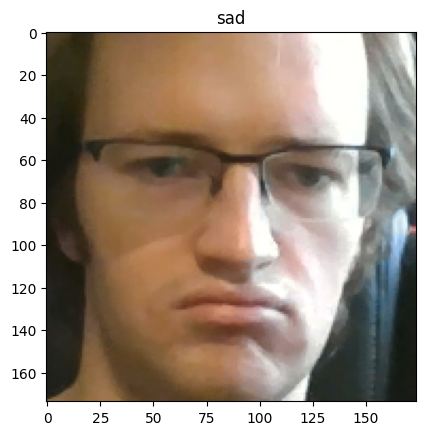

In [113]:
if frame is None:
    print(pred)
else: 
    plt.imshow(frame)
    plt.title(pred)
    plt.show()